# TensorFlow 2.0 Text generator on Dante Alighieri's Divine Comedy

Author: **Ivan Bongiorni**, [LinkedIn profile](https://www.linkedin.com/in/ivan-bongiorni-b8a583164/)


This Notebook contains a **text generator RNN** that was trained on the **Divina Commedia** (the *Divine Comedy*) by **Dante Alighieri**. This is a poem written at the beginning of the XII century. It's hard to explain what it represents for Italian culture: it's without any doubt the main pillar of our national literature, one of the building blocks of modern Italian language, and arguably the gratest poem ever. All modern representations of Hell, Purgatory and Heaven derive from this opera.

It's structure is extremely interesting: each verse is composed of 11 syllables, and its rhymes follow an **A-B-A-B** structure. Lot of pattern to be learned! 

In [1]:
import time
import re

import numpy as np
import pandas as pd

%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

from matplotlib import pyplot as plt

# Read file from Colab Notebook
from google.colab import drive
drive.mount('/content/drive')

TensorFlow 2.x selected.
2.1.0-rc1
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
current_path = " [...] /TF_2.0/NLP/text_generator/"

# Read the Divina Commedia
with open(current_path + "DivinaCommedia.txt", 'r', encoding="utf8") as file:
    divina_commedia = file.read()

# Replace rare characters
divina_commedia = divina_commedia.replace("ä", "a")
divina_commedia = divina_commedia.replace("é", "è")
divina_commedia = divina_commedia.replace("ë", "è")
divina_commedia = divina_commedia.replace("Ë", "E")
divina_commedia = divina_commedia.replace("ï", "i")
divina_commedia = divina_commedia.replace("Ï", "I")
divina_commedia = divina_commedia.replace("ó", "ò")
divina_commedia = divina_commedia.replace("ö", "o")
divina_commedia = divina_commedia.replace("ü", "u")

divina_commedia = divina_commedia.replace("(", "-")
divina_commedia = divina_commedia.replace(")", "-")
divina_commedia = divina_commedia.replace("[", "")
divina_commedia = divina_commedia.replace("]", "")

divina_commedia = re.sub(r'[0-9]+', '', divina_commedia)
divina_commedia = divina_commedia.replace(" \n", "\n")

In [3]:
# Check lenght of text
print(len(divina_commedia))

551697


I will now extract the set of unique characters, and create a dictionary for vectorization of text. In order to feed the text into a Neural Network, I must turn each character into a number.

In [0]:
# Store unique characters into a dict with numerical encoding
unique_chars = list(set(divina_commedia))
unique_chars.sort()  # to make sure you get the same encoding at each run

# Store them in a dict, associated with a numerical index
char2idx = { char[1]: char[0] for char in enumerate(unique_chars) }


In [5]:
print(len(char2idx))

63


In [6]:
char2idx

{'\n': 0,
 ' ': 1,
 '!': 2,
 '"': 3,
 "'": 4,
 ',': 5,
 '-': 6,
 '.': 7,
 ':': 8,
 ';': 9,
 '?': 10,
 'A': 11,
 'B': 12,
 'C': 13,
 'D': 14,
 'E': 15,
 'F': 16,
 'G': 17,
 'H': 18,
 'I': 19,
 'L': 20,
 'M': 21,
 'N': 22,
 'O': 23,
 'P': 24,
 'Q': 25,
 'R': 26,
 'S': 27,
 'T': 28,
 'U': 29,
 'V': 30,
 'X': 31,
 'Z': 32,
 'a': 33,
 'b': 34,
 'c': 35,
 'd': 36,
 'e': 37,
 'f': 38,
 'g': 39,
 'h': 40,
 'i': 41,
 'j': 42,
 'l': 43,
 'm': 44,
 'n': 45,
 'o': 46,
 'p': 47,
 'q': 48,
 'r': 49,
 's': 50,
 't': 51,
 'u': 52,
 'v': 53,
 'x': 54,
 'y': 55,
 'z': 56,
 'È': 57,
 'à': 58,
 'è': 59,
 'ì': 60,
 'ò': 61,
 'ù': 62}

Once I have a dictionary that maps each characted with its respective numerical index, I can process the whole corpus.

In [0]:
def numerical_encoding(text, char_dict):
    """ Text to list of chars, to np.array of numerical idx """
    chars_list = [ char for char in text ]
    chars_list = [ char_dict[char] for char in chars_list ]
    chars_list = np.array(chars_list)
    return chars_list


In [8]:
# Let's see what the first line will look like
print("{}".format(divina_commedia[276:311]))
print("\nbecomes:")
print(numerical_encoding(divina_commedia[276:311], char2idx))

Nel mezzo del cammin di nostra vita

becomes:
[22 37 43  1 44 37 56 56 46  1 36 37 43  1 35 33 44 44 41 45  1 36 41  1
 45 46 50 51 49 33  1 53 41 51 33]


## RNN dataprep

I need to generate a set of stacked input sequences. My goal is to train a Neural Network to find a mapping between an input sequence and an output sequence of equal length, in which each character is shifted left of one position.

For example, the first verse:

> Nel mezzo del cammin di nostra vita

would be translated in a train sequence as:

`Nel mezzo del cammin di nostra vit`

be associated with the target sequence:

`el mezzo del cammin di nostra vita`

The following function is a preparatory step for that. More generally, given a sequence:

```
A B C D E F G H I
```

and assuming input sequences of length 5, it will generate a matrix like:

```
A B C D E
B C D E F
C D E F G
D E F G H
E F G H I
```

I will save that matrix as it is in .csv format, to use it to train the Language Generator later.
The split between train and target sets will be as:

```
 Train:           Target:
                 
A B C D E        B C D E F
B C D E F        C D E F G
C D E F G        D E F G H
D E F G H        E F G H I
                 
```

Train and target sets are fundamentally the same matrix, with the train having the last row removed, and the target set having the first removed.

In [0]:
# Apply it on the whole Comedy
encoded_text = numerical_encoding(divina_commedia, char2idx)

In [0]:
def get_text_matrix(sequence, len_input):
    
    # create empty matrix
    X = np.empty((len(sequence)-len_input, len_input))
    
    # fill each row/time window from input sequence
    for i in range(X.shape[0]):
        X[i,:] = sequence[i : i+len_input]
        
    return X

In [0]:
text_matrix = get_text_matrix(encoded_text, 100)

In [12]:
print(text_matrix.shape)

(551597, 100)


In [13]:
print("100th train sequence:\n")
print(text_matrix[ 100, : ])
print("\n\n100th target sequence:\n")
print(text_matrix[ 101, : ])

100th train sequence:

[45. 37.  1. 37.  1. 47. 52. 45. 41. 44. 37. 45. 51. 41.  1. 36. 37.  4.
  1. 53. 41. 56. 41.  1. 37.  1. 36. 37.  4.  1. 44. 37. 49. 41. 51. 41.
  1. 37.  1. 47. 49. 37. 44. 41.  1. 36. 37.  1. 43. 37.  1. 53. 41. 49.
 51. 62.  7.  1. 13. 46. 44. 41. 45. 35. 41. 33.  1. 41. 43.  1. 35. 33.
 45. 51. 46.  1. 47. 49. 41. 44. 46.  1. 36. 37.  1. 43. 33.  1. 47. 49.
 41. 44. 33.  1. 47. 33. 49. 51. 37.  1.]


100th target sequence:

[37.  1. 37.  1. 47. 52. 45. 41. 44. 37. 45. 51. 41.  1. 36. 37.  4.  1.
 53. 41. 56. 41.  1. 37.  1. 36. 37.  4.  1. 44. 37. 49. 41. 51. 41.  1.
 37.  1. 47. 49. 37. 44. 41.  1. 36. 37.  1. 43. 37.  1. 53. 41. 49. 51.
 62.  7.  1. 13. 46. 44. 41. 45. 35. 41. 33.  1. 41. 43.  1. 35. 33. 45.
 51. 46.  1. 47. 49. 41. 44. 46.  1. 36. 37.  1. 43. 33.  1. 47. 49. 41.
 44. 33.  1. 47. 33. 49. 51. 37.  1. 43.]


# Architecture

At this point, I can specify the RNN architecture with all its hyperparameters. An `Embedding()` layer will first learn a representation of each character; the sequence of chracters embedding will then be fed into an `LSTM()` layer, that will extract information from their sequence; `Dense()` layers at the end will produce the next character prediction.

The Network is structured to be fed with batches of data of fixed size.

In [0]:
# size of vocabulary
vocab_size = len(char2idx)

# size of mini batches during training
batch_size = 100

# size of training subset at each epoch
subset_size = batch_size * 100

# vector size of char embeddings
embedding_size = 250

len_input = 1000   # 200

hidden_size = 250  # for Dense() layers

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.activations import elu, relu, softmax

In [16]:
RNN = Sequential([
    Embedding(vocab_size, embedding_size,
              batch_input_shape=(batch_size, None)),
    
    LSTM(len_input, return_sequences = True),
    
    Dense(hidden_size, activation = relu), 
    
    Dense(vocab_size)
])

RNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (100, None, 250)          15750     
_________________________________________________________________
lstm (LSTM)                  (100, None, 1000)         5004000   
_________________________________________________________________
dense (Dense)                (100, None, 250)          250250    
_________________________________________________________________
dense_1 (Dense)              (100, None, 63)           15813     
Total params: 5,285,813
Trainable params: 5,285,813
Non-trainable params: 0
_________________________________________________________________


In [0]:
n_epochs = 100

learning_rate = 0.0001
optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)

In [0]:
# This is an Autograph function
# its decorator makes it a TF op - i.e. much faster
@tf.function
def train_on_batch(x, y):
    with tf.GradientTape() as tape:
        current_loss = tf.reduce_mean(
            tf.keras.losses.sparse_categorical_crossentropy(
                y, RNN(x), from_logits = True))
    gradients = tape.gradient(current_loss, RNN.trainable_variables)
    optimizer.apply_gradients(zip(gradients, RNN.trainable_variables))
    return current_loss

In [19]:
loss_history = []

for epoch in range(n_epochs):
    start = time.time()
    
    # Take subsets of train and target
    sample = np.random.randint(0, text_matrix.shape[0]-1, subset_size)
    sample_train = text_matrix[ sample , : ]
    sample_target = text_matrix[ sample+1 , : ]
    
    for iteration in range(sample_train.shape[0] // batch_size):
        take = iteration * batch_size
        x = sample_train[ take:take+batch_size , : ]
        y = sample_target[ take:take+batch_size , : ]

        current_loss = train_on_batch(x, y)
        loss_history.append(current_loss)
    
    print("{}.  \t  Loss: {}  \t  Time: {}ss".format(
        epoch+1, current_loss.numpy(), round(time.time()-start, 2)))

1.  	  Loss: 3.072500705718994  	  Time: 14.92ss
2.  	  Loss: 2.957970142364502  	  Time: 7.59ss
3.  	  Loss: 2.577200412750244  	  Time: 7.58ss
4.  	  Loss: 2.415374517440796  	  Time: 7.59ss
5.  	  Loss: 2.3381526470184326  	  Time: 7.59ss
6.  	  Loss: 2.260857343673706  	  Time: 7.58ss
7.  	  Loss: 2.2402889728546143  	  Time: 7.58ss
8.  	  Loss: 2.1702616214752197  	  Time: 7.59ss
9.  	  Loss: 2.137619733810425  	  Time: 7.58ss
10.  	  Loss: 2.1122875213623047  	  Time: 7.6ss
11.  	  Loss: 2.0589234828948975  	  Time: 7.59ss
12.  	  Loss: 2.056528091430664  	  Time: 7.59ss
13.  	  Loss: 2.027541399002075  	  Time: 7.59ss
14.  	  Loss: 2.005847454071045  	  Time: 7.59ss
15.  	  Loss: 2.0110795497894287  	  Time: 7.63ss
16.  	  Loss: 1.9466191530227661  	  Time: 7.58ss
17.  	  Loss: 1.9405425786972046  	  Time: 7.58ss
18.  	  Loss: 1.9408313035964966  	  Time: 7.57ss
19.  	  Loss: 1.9250353574752808  	  Time: 7.58ss
20.  	  Loss: 1.8843433856964111  	  Time: 7.57ss
21.  	  Loss: 1.89

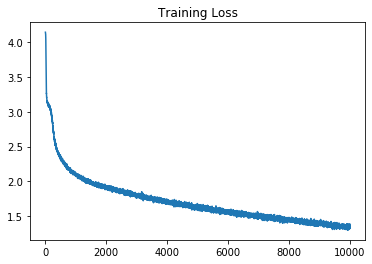

In [20]:
plt.plot(loss_history)
plt.title("Training Loss")
plt.show()

In [0]:
RNN.save(current_path + "models/text_generator_RNN_00.h5")

# Text Generation

At this point, let's check how the model generates text. In order to do it, I must make some changes to my RNN architecture above.

First, I must change the fixed batch size. After training, I want to feed just one sentence into my Network to make it continue the character sequence. I will feed a string into the model, make it predict the next character, update the input sequence, and repeat the process until a long generated text is obtained. Because of this, the succession of input sequences is now different from training session, in which portions of text were sampled randomly. I now have to set `stateufl = True` in the `LSTM()` layer, so that each LSTM cell will keep in memory the internal state from the previous sequence. With this I hope the model will better remember sequential information while generating text.

I will instantiate a new `generator` RNN with these new features, and transfer the trained weights of my `RNN` into it.

In [22]:
generator = Sequential([
    Embedding(vocab_size, embedding_size,
              batch_input_shape=(1, None)),
    
    LSTM(len_input, return_sequences = True, stateful=True),
    
    Dense(hidden_size, activation = relu), 
    
    Dense(vocab_size)
])

generator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (1, None, 250)            15750     
_________________________________________________________________
lstm_1 (LSTM)                (1, None, 1000)           5004000   
_________________________________________________________________
dense_2 (Dense)              (1, None, 250)            250250    
_________________________________________________________________
dense_3 (Dense)              (1, None, 63)             15813     
Total params: 5,285,813
Trainable params: 5,285,813
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Import trained weights from RNN to generator
generator.set_weights(RNN.get_weights())

In [0]:
def generate_text(start_string, num_generate = 1000, temperature = 1.0):
    
    # Vectorize input string
    input_eval = [char2idx[s] for s in start_string]  
    input_eval = tf.expand_dims(input_eval, 0)
    
    text_generated = [] # List to append predicted chars 
    
    idx2char = { v: k for k, v in char2idx.items() }  # invert char-index mapping
    
    generator.reset_states()
    
    for i in range(num_generate):
        predictions = generator(input_eval)
        predictions = tf.squeeze(predictions, 0)
        
        # sample next char based on distribution and temperature
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
        
        input_eval = tf.expand_dims([predicted_id], 0)

        text_generated.append(idx2char[predicted_id])
        
    return (start_string + ''.join(text_generated))


(This function is based on [this tutorial](https://www.tensorflow.org/tutorials/text/text_generation).)

In [25]:
# Let's feed the first lines:
start_string = """
Nel mezzo del cammin di nostra vita
mi ritrovai per una selva oscura,
chè la diritta via era smarrita.

"""

for t in [0.1, 0.5, 1.0, 1.5, 2]:
    print("####### TEXT GENERATION - temperature = {}\n".format(t))
    print(generate_text(start_string = start_string, num_generate = 1000, temperature = 1.0))
    print("\n\n\n")

####### TEXT GENERATION - temperature = 0.1


Nel mezzo del cammin di nostra vita
mi ritrovai per una selva oscura,
chè la diritta via era smarrita.

E fui dentro li palmi in su lo diso,
e più di senti a la tigurar lormi,
puosi e perde, scendero posa è ragge,
di settare in foce lo dispettorio:

"se buatti fanti mal vita ricorse
del tul, sani, 'de da nostrin molte
che giattimenza, nona personazise;
crovente Perrai pieghi e dicerno lascio,

e la seco del condier da sè spirti;
poi rimasesti 'ntender'obbi frati,
sanza medesse, da sapir più segue.

Oh su per dal mondo è disse: "E come il nove,
nel mi ragga da Parla una uscisci
dove s'appossar riguardando vidi,
onde piante paia", mi disse, "pertegno
regnida qui tolvede avea bena".

Animmi ciò ud'amici acceroperi,
se non la templa".
E quell'anime che tu diudo:
voglia vòlto assai a la gente reva.

Ciò precedean perve in unsi scarria,
per che gramar precità? Fatti al cui l'otto,
villa qua noi e un viso da contalla
stesti e centrustalmente sì, p

The best generation is, IMHO, the one with `temperature = 1.5`. The sentences of course do not make sense, but it's amazing that such a simple model could achieve similar results, and generate absolutely Dante-esque text with just ~40 minutes of GPU training.

Many things could be done at this point:



*   Try fancier architectures, such as seq2seq. (I must say though that stacked RNNs didn't provide better results during prototyping.)
*   Try Attention models.
*   Longer training.
*   Adversarial training.

I'll try a lot of these techniques, alone and combined. My goal is to make a model that can learn the amazing structure of syllables and rhymes of the whole Comedy.



### Sources

The main source I used to learn to implement an RNN text generator is [this tutorial on the official TensorFlow website](https://www.tensorflow.org/tutorials/text/text_generation).